# Практическое задание к уроку 8. GAN

1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшении работы нейронной сети. Обучите на выбор:

- *VAE на fashion_mnist
- *GAN на одном классе CIFAR
- *классификатор на данных tfds (Kaggle, UCI)
- *семантическую сегментацию на данных tfds (Kaggle, UCI).

2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

#### 1. Обучение нейронной сети: VAE на fashion_mnist 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# слой семплирования sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a picture."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# энкодер encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
# decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
# класс модель по Model с особым шагом обучения train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [6]:
# Convolutional Variational AutoEncoder (VAE)

(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_images = np.concatenate([x_train, x_test], axis=0)
mnist_images = np.expand_dims(mnist_images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_images, epochs=20, batch_size=128)

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - 80s 144ms/step - loss: 352.5896 - reconstruction_loss: 349.4997 - kl_loss: 3.0898
Epoch 2/20
547/547 [==============================] - 70s 128ms/step - loss: 312.3095 - reconstruction_loss: 308.4541 - kl_loss: 3.8554
Epoch 3/20
547/547 [==============================] - 68s 125ms/step - loss: 304.0593 - reconstruction_loss: 300.5868 - kl_loss: 3.4725
Epoch 4/20
547/547 [==============================] - 73s 133ms/step - loss: 300.1568 - reconstruction_loss: 296.9211 - kl_loss: 3.2357
Epoch 5/20
547/547 [==============================] - 74s 135ms/step - loss: 298.2446 - reconstruction_loss: 294.9996 - kl_loss: 3.2450
Epoch 6/20
547/547 [==============================] - 70s 127ms/step - loss: 294.4089 - reconstruction_loss: 290.7138 - kl_loss: 3.6951
Epoch 7/20
547/547 [==============================] - 69s 127ms/step - loss: 291.4067 - reconstruction_loss: 287.6082 - k

In [7]:
vae.fit(mnist_images, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 69s 126ms/step - loss: 259.9933 - reconstruction_loss: 255.9753 - kl_loss: 4.0180
Epoch 2/20
547/547 [==============================] - 69s 126ms/step - loss: 259.5805 - reconstruction_loss: 255.6084 - kl_loss: 3.9720
Epoch 3/20
547/547 [==============================] - 69s 126ms/step - loss: 259.3275 - reconstruction_loss: 255.3813 - kl_loss: 3.9462
Epoch 4/20
547/547 [==============================] - 69s 127ms/step - loss: 259.0013 - reconstruction_loss: 255.0770 - kl_loss: 3.9244
Epoch 5/20
547/547 [==============================] - 69s 127ms/step - loss: 258.6808 - reconstruction_loss: 254.7643 - kl_loss: 3.9165
Epoch 6/20
547/547 [==============================] - 69s 126ms/step - loss: 258.4768 - reconstruction_loss: 254.5756 - kl_loss: 3.9012
Epoch 7/20
547/547 [==============================] - 69s 126ms/step - loss: 258.1933 - reconstruction_loss: 254.2987 - kl_loss: 3.8945
Epoch 8/20
547/547 [============================

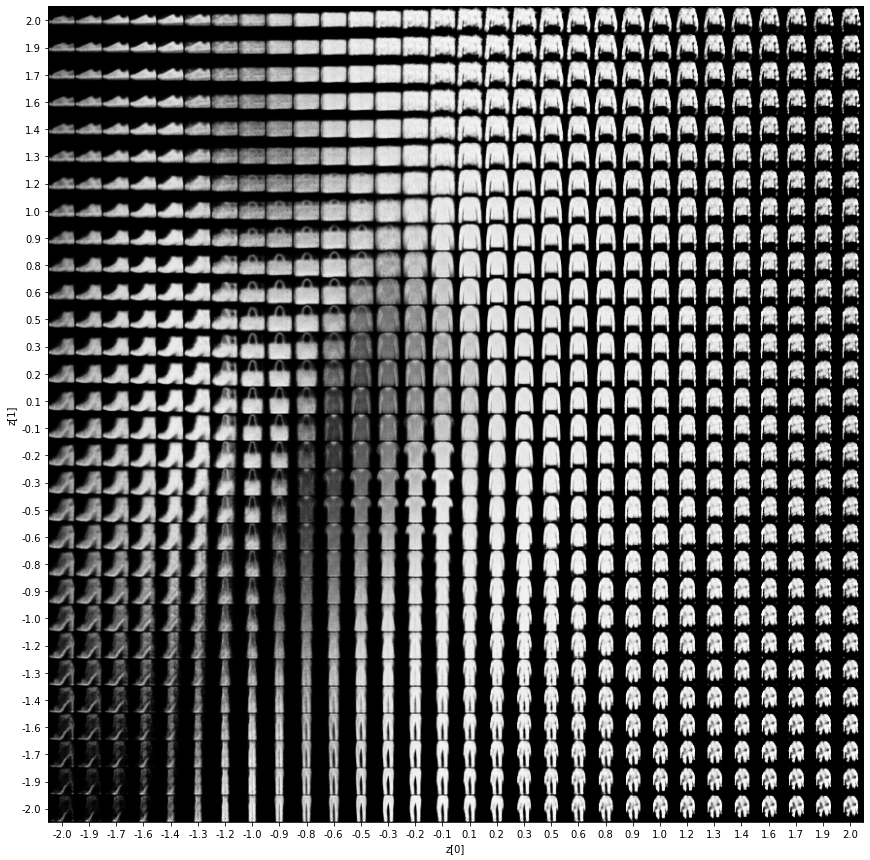

In [8]:
# результат предсказания для предмета

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range #+ 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

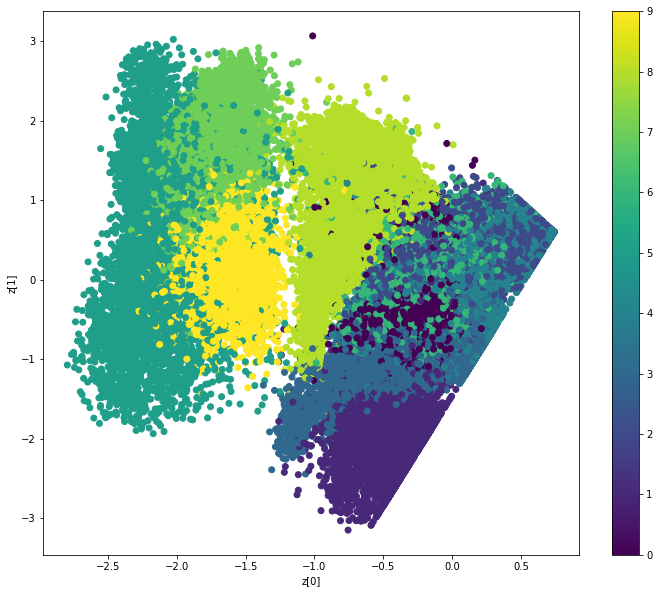

In [9]:
# кластеры в скрытом пространстве

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

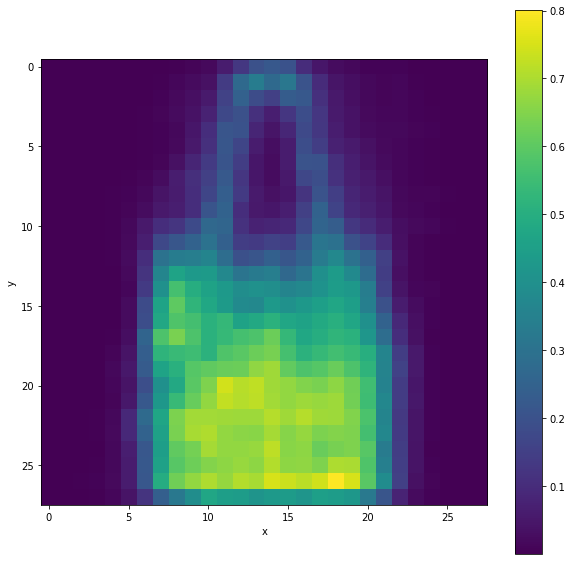

In [10]:
# 2D-графика классов предметов в скрытом пространстве

def plot_item_from_decoder(decoder, z, item_size):
    
    data = np.array([[z[0], z[1]]])
    item = decoder.predict(data)
    item = item.reshape(item_size, item_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(item)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_item_from_decoder(decoder, [-1,-0.5], 28)

**Выводы:**

1. Точность результата увеличивается при увеличении количества эпох и заметно снижается при уменьшении размера batch. 

2. При увеличении размера batch точность повышается, но кластеры выстраиваются в прямую линию, демонстрируя переобучение.

#### 2. Краткий обзор архитектуры Self Organizing Maps (SOMs)


Особенности:

- обучение без учителя
- снижает размерность с многомерного пространства до двухмерного

Принцип работы:

- определяет веса для каждого узла
- определяет BMU (лучший подходящий блок) - узла на карте, вектор веса которого меньше всего отличается от наблюдения (в метрике, задаваемой аналитиком, чаще всего, евклидовой)
- перераспределяет веса в зависимости от расстояния до BMU - чем дальше, тем меньше

Отличия от других архитектур:

- использует неконтролируемое обучение (учится понимать структуру данных)
- очень проста и представляет собой два слоя: входной и выходной (самоорганизующаяся карта)

Источники:

1) https://www.simplilearn.com/tutorials/deep-learning-tutorial/deep-learning-algorithm

2) https://intuit.ru/studies/courses/6/6/lecture/180?page=3